In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras import Sequential

import os
import matplotlib.pyplot as plt


img_size = 128  #64 for conv 1
b_size = 64  

2024-03-31 10:18:06.389262: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-31 10:18:06.389368: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-31 10:18:06.526840: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
device_name = tf.test.gpu_device_name()
#if device_name != '/device:GPU:0':
  #raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


**Image Augmentation and Flow from Directory**

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_gen = ImageDataGenerator(rescale  = 1./255,
                             zoom_range = .1,
                            horizontal_flip=True,
                            brightness_range= (0.8,1.2),
                            validation_split = .1)

test_gen = ImageDataGenerator(rescale  = 1./255) #preparation through evaluation


train_dataset = img_gen.flow_from_directory(
    '/kaggle/input/rvf10k/rvf10k/train',
    target_size=(img_size, img_size),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=b_size,
    subset="training",

)
val_dataset = img_gen.flow_from_directory(
    '/kaggle/input/rvf10k/rvf10k/train',
    target_size=(img_size, img_size),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=b_size,
    subset="validation",
)

test_dataset = test_gen.flow_from_directory(
    '/kaggle/input/rvf10k/rvf10k/valid',
    target_size=(img_size, img_size),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=b_size,
    #subset=None,
)


Found 6300 images belonging to 2 classes.
Found 700 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.


**Small Net for Testing**

In [5]:
def build_cnn_1():
    model = tf.keras.models.Sequential([
      layers.Conv2D(30, 3, padding='same', activation='relu', input_shape = (img_size, img_size, 3)),
      layers.BatchNormalization(),
      layers.MaxPooling2D(),
      layers.Conv2D(30, 3, padding='same', activation='relu'),
      layers.BatchNormalization(),
      layers.MaxPooling2D(),
      layers.Conv2D(50, 3, padding='same', activation='relu'),
      layers.BatchNormalization(),
      layers.MaxPooling2D(),
      layers.Conv2D(70, 3, padding='same', activation='relu'),
      layers.BatchNormalization(),
      layers.MaxPooling2D(),
        
      layers.Flatten(),
      layers.Dense(500, activation='relu'),
      layers.Dense(2, activation='softmax')
    ])
    return model

**Transfer Learning Model with MobileNetV2, add new untrained classification end**

In [6]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Model

def build_cnn_2():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
    for layer in base_model.layers: #freeze all layers
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(tfl.GlobalAveragePooling2D())      #flatten end convolution layers
    model.add(tfl.Dense(512, activation='relu'))  #connect features with new untrained end classifier layer
    model.add(tfl.BatchNormalization())  #connect features with new untrained end classifier layer
    model.add(tfl.Dropout(.4))
    model.add(tfl.Dense(2, activation='softmax')) #make two prediction neurons

    return model

In [7]:
model = build_cnn_2()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
optimizer = "adam" #tf.keras.optimizers.Adam(0.0001)
model.compile(optimizer = optimizer, metrics = ["accuracy","f1_score"], loss = "categorical_crossentropy")


In [9]:
history = model.fit(train_dataset, validation_data = val_dataset, epochs = 10)
#steps_per_epoch = len(train_dataset)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 1/99 ━━━━━━━━━━━━━━━━━━━━ 29:37 18s/step - accuracy: 0.3906 - f1_score: 0.3783 - loss: 1.5395

I0000 00:00:1711880319.064422      89 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


99/99 ━━━━━━━━━━━━━━━━━━━━ 92s 749ms/step - accuracy: 0.6139 - f1_score: 0.6137 - loss: 0.9624 - val_accuracy: 0.6786 - val_f1_score: 0.6693 - val_loss: 0.6526
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 37s 353ms/step - accuracy: 0.7105 - f1_score: 0.7104 - loss: 0.5863 - val_accuracy: 0.7129 - val_f1_score: 0.7092 - val_loss: 0.5740
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 38s 358ms/step - accuracy: 0.7396 - f1_score: 0.7395 - loss: 0.5292 - val_accuracy: 0.7157 - val_f1_score: 0.7145 - val_loss: 0.5518
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 38s 358ms/step - accuracy: 0.7556 - f1_score: 0.7556 - loss: 0.4986 - val_accuracy: 0.7229 - val_f1_score: 0.7226 - val_loss: 0.5580
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 38s 361ms/step - accuracy: 0.7561 - f1_score: 0.7560 - loss: 0.4978 - val_accuracy: 0.7243 - val_f1_score: 0.7243 - val_loss: 0.5596
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 38s 362ms/step - accuracy: 0.7642 - f1_score: 0.7641 - loss: 0.4683 - val_accuracy: 0.7271 - val_f1_score: 0.7248 - va

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,232,776 (16.15 MB)

 Trainable params: 657,922 (2.51 MB)

 Non-trainable params: 2,259,008 (8.62 MB)

 Optimizer params: 1,315,846 (5.02 MB)

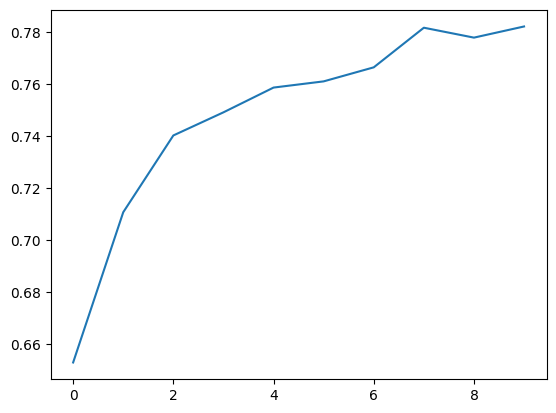

In [11]:
plt.plot(history.history["accuracy"])

In [12]:
model.evaluate(test_dataset)

47/47 ━━━━━━━━━━━━━━━━━━━━ 24s 509ms/step - accuracy: 0.7214 - f1_score: 0.7196 - loss: 0.5690


[0.5686824917793274,
 0.7246666550636292,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.74379647, 0.7024495 ], dtype=float32)>]

**Printing Some Images from Test dataset with corresponding prediction and label of the images**

2/2 - 5s - 3s/step


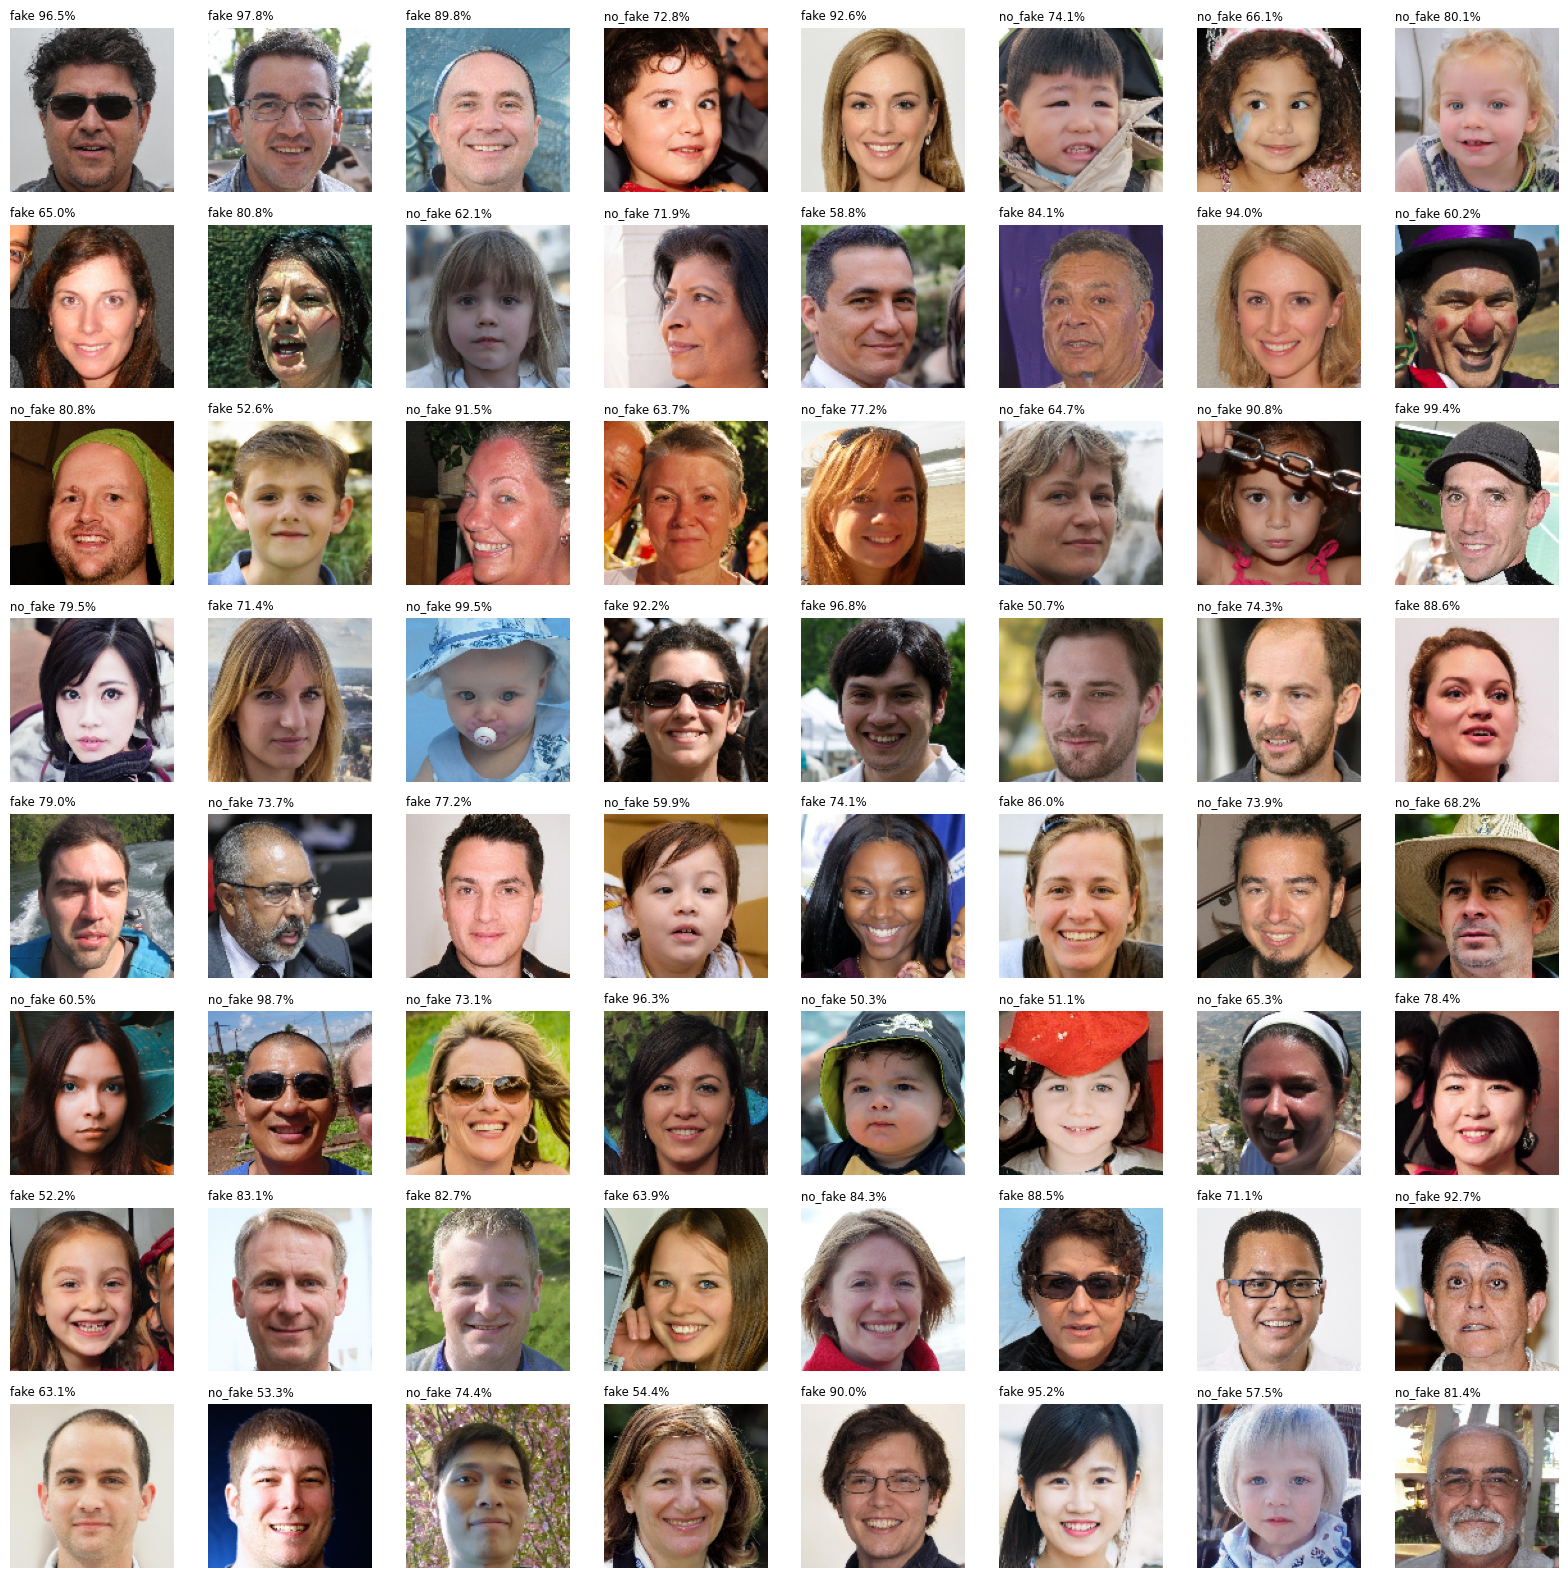

In [13]:
#print some results
import matplotlib.pyplot as plt
import numpy as np

images = []
labels = []

classes = ["fake", "no_fake"]

for imgbatch in test_dataset: #each i contains one batch of images      #train_generator for viz augmented data
  images = imgbatch[0]
  labels = imgbatch[1]
  break

predictions = model.predict(images, verbose = 2)
##print(predictions)

fig, (axs) = plt.subplots(8,8,figsize=(20, 20))

for nn, ax in enumerate(axs.flat):
    ax.imshow(images[nn])
    predictLabel = classes[np.argmax(predictions[nn])]
    predictConf = max(predictions[nn])
    labelString = str(predictLabel+" "+str(int(1000*predictConf)/10)+ "%")#+classes[np.argmax(labels[nn])]
    ax.set_title(labelString, fontsize='small', loc='left')
    ax.axis('off')

plt.show()

### Functions